### Importing important libraries

In [214]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.33.2'

In [215]:
import qiskit

qiskit.version.get_version_info()

'1.2.4'

In [216]:
# Built-in modules
import math
import numpy as np

# Imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, PhaseEstimation
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

#### Chosing Backend

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
# backend = AerSimulator()
backend.name

'aer_simulator'

### Useful functions

In [218]:
def function_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

def generate_sequence(alphabet, probabilities, N):
    """
    Generate a sequence of characters from the given alphabet based on the given probabilities.

    Parameters:
        alphabet (list): List of characters.
        probabilities (list): List of probabilities corresponding to the characters in the alphabet.
        N (int): Length of the sequence to be generated.

    Returns:
        str: Generated sequence of characters.
    """
    # Generate the sequence
    sequence = np.random.choice(alphabet, size=N, p=probabilities)
    # Join the sequence
    sequence = ''.join(sequence)
    return sequence

# Convert the sequence to a binary string
def convert_to_binary_string(sequence, charac):
    """
    Convert a sequence of characters from {a, b, c, d} to a binary string.
    Replace 'charac' with '1' and all other characters with '0'.

    Parameters:
        sequence (str): Input sequence of characters.
        charac (str): Character to be replaced with '1'.

    Returns:
        str: Binary string with '1' for 'charac' and '0' for other characters.
    """
    binary_string = ''.join(['1' if char == charac else '0' for char in sequence])
    return binary_string



In [222]:
# Define the alphabet and their corresponding probabilities
alphabet = ['a', 'b', 'c', 'd']
probabilities = [0.2, 0.3, 0.1, 0.4]
# Define the length of the sequence
N = 10  # Example length, you can change this to any desired length
epsilon = 0.1 # Error tolerance

# Generate a sequence of characters
sequence = generate_sequence(alphabet, probabilities, N)
binary_string = convert_to_binary_string(sequence, 'a')

print(sequence)
print(binary_string)

# Find the locations of '1' in the binary string and convert to binary representation
marked_states = [format(index, f'0{len(bin(N-1)[2:])}b') for index, char in enumerate(binary_string) if char == '1']
print(marked_states)

bbaddcadda
0010001001
['0010', '0110', '1001']


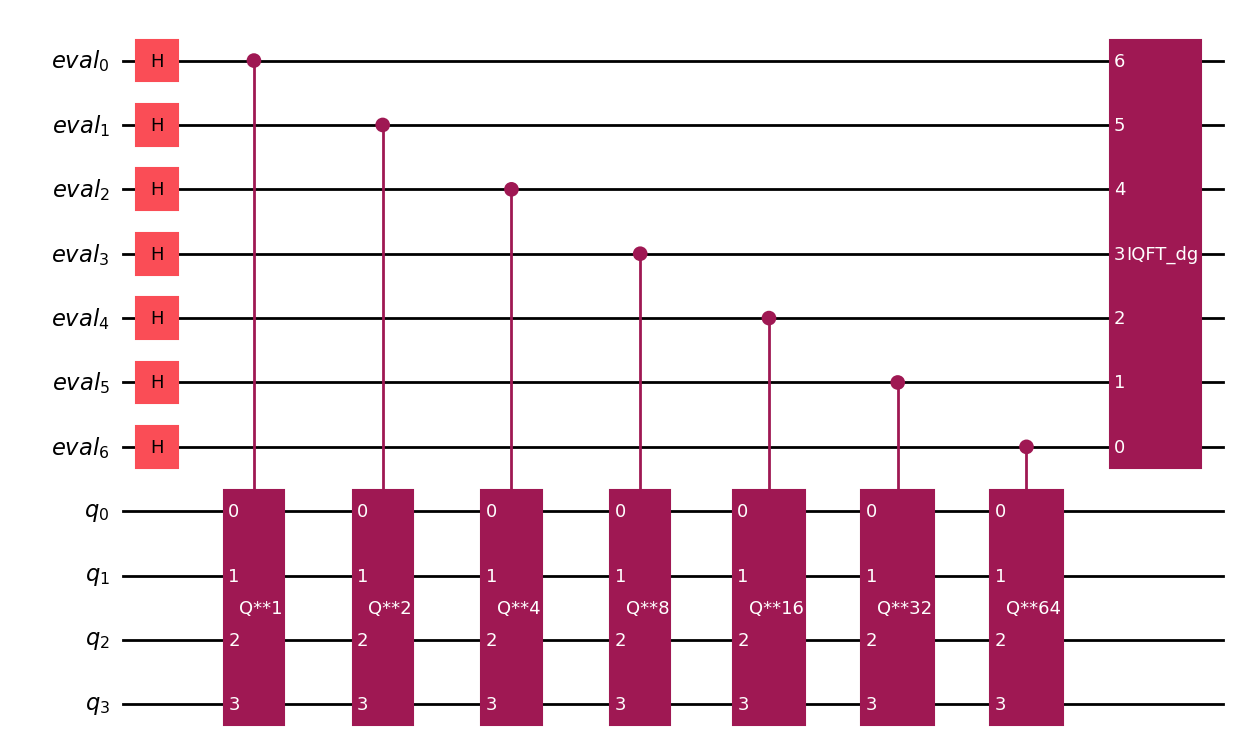

In [ ]:
oracle = function_oracle(marked_states)
grover_op = GroverOperator(oracle)
num_evaluation_qubits = grover_op.num_qubits + math.ceil(math.log2(2+(1/(2*epsilon))))
print("Number of evaluation qubits:", num_evaluation_qubits)
print("Number of qubits in the Grover operator:", grover_op.num_qubits)

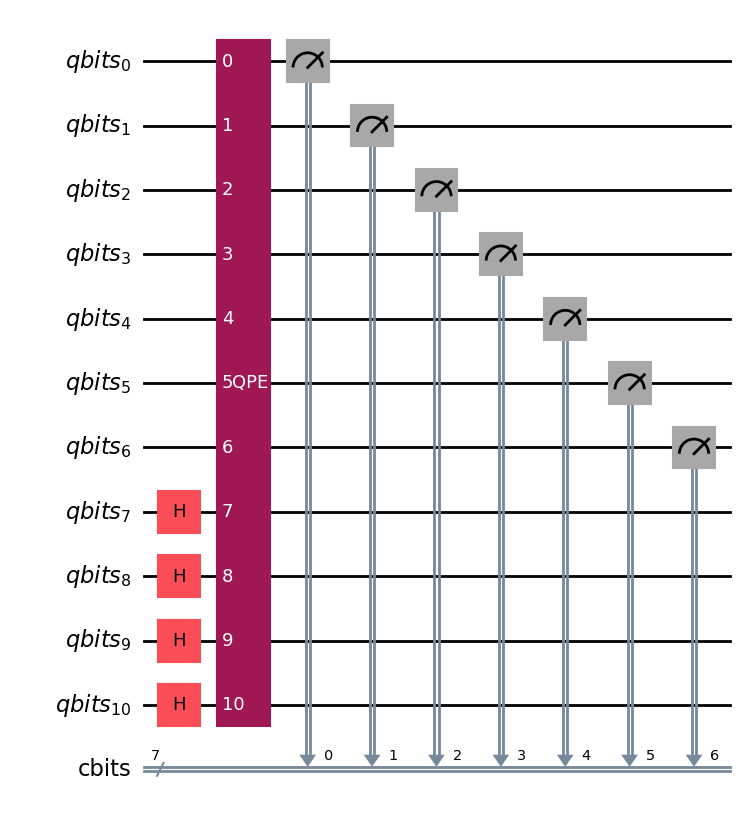

In [205]:
qbits = QuantumRegister(num_evaluation_qubits+grover_op.num_qubits,name='qbits')
cbits = ClassicalRegister(num_evaluation_qubits,name='cbits')
qc = QuantumCircuit(qbits,cbits,name='qc')
qc.h(range(num_evaluation_qubits, num_evaluation_qubits+grover_op.num_qubits))
qc.compose(PhaseEstimation(num_evaluation_qubits, unitary=grover_op), inplace=True)
# PhaseEstimation(num_evaluation_qubits, unitary=grover_op).decompose().draw(output="mpl", style="iqp")
qc.measure(range(num_evaluation_qubits), range(num_evaluation_qubits))
qc.draw(output="mpl", style="iqp")

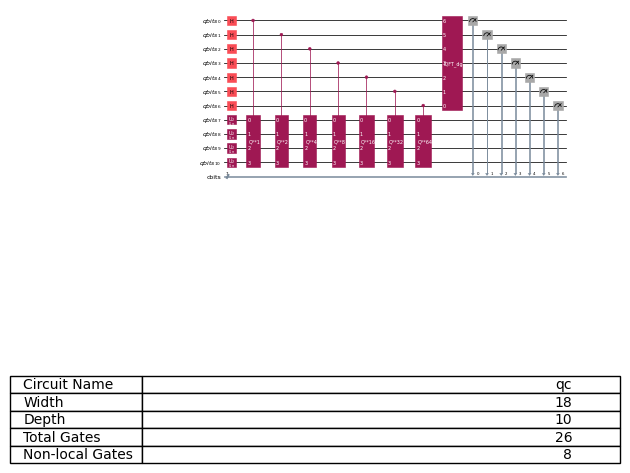

In [206]:
_generate_circuit_library_visualization(qc)

In [197]:
# backend = AerSimulator()
target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [207]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.cbits.get_counts()

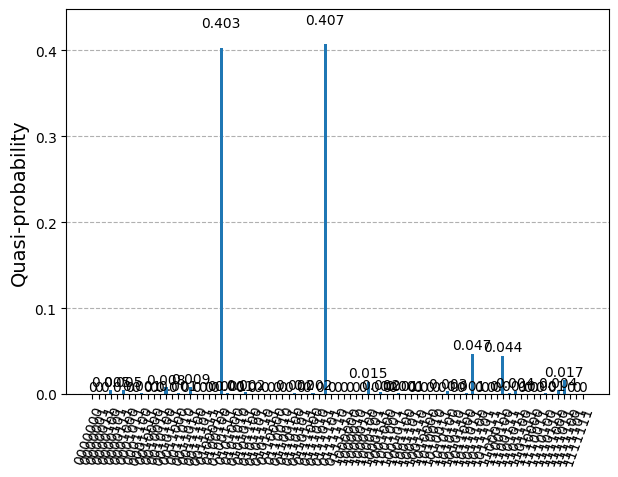

In [208]:
plot_distribution(dist)

In [209]:
print("Original sequence:", sequence)
print("Binary string:", binary_string)
print("Marked states (locations of '1'):", marked_states)

Original sequence: dcdadbacdd
Binary string: 0001001000
Marked states (locations of '1'): ['0011', '0110']


In [210]:
# Find the maximum value in the distribution
max_key = max(dist, key=dist.get)
max_key


'0111011'

In [212]:
# Conver the max_key to decimal
max_key_decimal = int(max_key, 2)
max_key_decimal/2**num_evaluation_qubits

0.4609375

In [213]:
(math.sin(max_key_decimal/2**num_evaluation_qubits))**2

0.19783633021898178